# Text Dating: A Study in Document Regression

[Document classification](https://en.wikipedia.org/wiki/Document_classification) is a common application of machine learning techniques. Examples include [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), the classification of texts into a (typically small) number of moods (such as "positive" and "negative"); as well as authorship attribution in [stylometry](https://en.wikipedia.org/wiki/Stylometry), in which texts are grouped according to their original author.

Unsupersived learning methods have also been applied to the analysis of documents. For instance, [doc2vec](https://arxiv.org/pdf/1405.4053v2.pdf) is a dimensionality reduction technique that extends [word embeddings] to documents.

But what about document *regression*? In this notebook, we investigate the problem of learning the date of a publication from the text contained therein. Since the target space, a range of years, can be viewed as a continuum, this problem presents a natural test case for applying regression techniques to document analysis.

In [1]:
import re
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## The Gutenberg dataset

We will make use of the (updated) [Gutenberg dataset](https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html), which consists of complete texts from over 3000 public domain books.

Unfortunately, the documents have already been stripped of metadata, including the year of publication. We attempt to resolve this issue by supposing that the first four-digit number appearing in each document (if any) is the date of publication.

The following loads texts for which a potential year of publication can be found into a dataframe. The texts are lowercased, stripped of all content up to and including the year (presumably front matter), and (most importantly) stripped of the author's last name.

In [43]:
%%time
text_dir = 'data/texts'
current_year = 2020

files = [file for file in os.listdir(text_dir) if '___' in file]

entries = []
for file in files:
    # author and title are embedded in the file name
    author, title = file.split('___')
    title = title.split('.txt')[0]
    
    with open(os.path.join(text_dir, file)) as f:
        text = f.read().lower()
        
        # search for the first occurence of a 4-digit number
        match = re.search('\d\d\d\d', text)
        
        if match:
            i = match.start()
            year = int(text[i:i+4])
            
            # remove front matter and author name
            text = text[i+5:].lower()
            text = re.sub(author.split()[-1].lower(), '', text)
            
            # filter out impossible years
            if year <= current_year:
                entries.append((author, title, year, text))

docs = pd.DataFrame(entries, columns=['author', 'title', 'year', 'text'])

CPU times: user 22.6 s, sys: 1.31 s, total: 23.9 s
Wall time: 29 s


### A first look at the data

The `docs` dataframe contains author, title, (estimated) year of publication, and full text.

In [3]:
docs.head()

,author,title,year,text
0,Charles Kingsley,The Heroes,1889,\n _the right of translation ...
1,Oscar Wilde,Poems,1896,"\n\ni\n\nhe did not wear his scarlet coat,\nfo..."
2,Robert Louis Stevenson,The Works of Robert Louis Stevenson - Swanston...,1813,that i was so unlucky as to fall at last\ninto...
3,Louisa May Alcott,On Picket Duty and Other Tales,1864,\n\n\n\non picket duty.\n\n\n_what_ air you th...
4,Herman Melville,Israel Potter,1855,\n\n\n\ndedication\n\nto his highness the bunk...


The texts will need to be cleaned, but before we do that let's examine the year distribution. The plot below suggests an exponentially growing publication count throughout the years. This is actually quite reassuring in regards to our method for guessing publication date. However, this imbalance may be problematic later in our analysis and should be taken into account.

The sudden decrease in the number of publications in more recent years is likely explained by copyright law. The table shows the decrease beginning in the 1920s.

In [37]:
pd.DataFrame(docs.groupby('year').size().tail(25)).transpose()

year,1919,1920,1921,1922,1923,1924,1925,1927,1930,1932,...,1966,1967,1970,1972,1976,1980,1988,1991,2000,2006
0,29,30,26,26,3,2,1,1,2,1,...,2,1,1,1,2,1,1,2,16,1


The beginning of the histogram also contains an apparent anomaly, with a spike in publication count in the 11th century. As the table below shows, this is likely due to the disproportionate likelihood of the number 1000 appearing in a text.

In [40]:
pd.DataFrame(docs.groupby('year').size().head(10)).transpose()

year,1000,1001,1002,1007,1035,1050,1066,1090,1092,1099
0,10,3,1,2,2,2,2,1,1,2


We'll filter out this anomaly as well as the smaller number of publications after 1922.

In [44]:
docs = docs[(docs['year'] > 1000) & (docs['year'] < 1923)]

We still have some outliers to account for, as indicated in the box plot below.

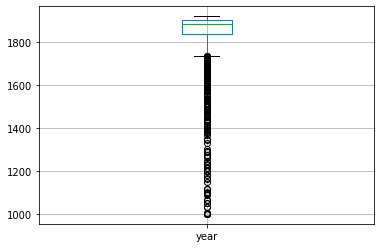

In [45]:
bp_data = docs.boxplot('year', return_type='dict')

We'll restrict our attention to the range of years between the min and max whiskers.

In [46]:
whisker_data = [whisker.get_ydata() for whisker in bp_data['whiskers']]
start = int(whisker_data[0][1])
stop = int(whisker_data[1][1])
start, stop

(1738, 1922)

In [47]:
docs = docs[(docs['year'] > start) & (docs['year'] < stop)]

Within our selected range, the growth in the number of publications is much more regular.

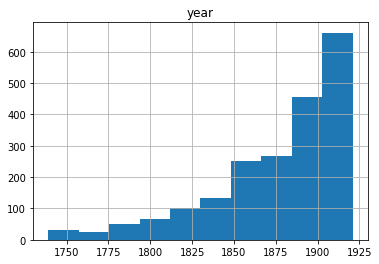

In [242]:
_ = docs.hist('year')

## Preprocessing

### Cleaning

Our main goal is to see if we can infer publication date from the words contained in a text. However, we might also conjecture that certain non-word features, such as punctuation density, may have some weight on our regression strategy.

The following first saves various punctuation statistics into a new dataframe and then cleans the texts, leaving only letters and white space. Note that we didn't use Pandas' more concise [string methods](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) for this task, as we found them to be significantly slower.

In [48]:
# construct the features dataframe for later use
features = pd.DataFrame()
features['year'] = docs['year']
features['length'] = docs['text'].str.len()
features['words'] = docs['text'].map(lambda text: len(text.split()))
features['sentences'] = docs['text'].map(lambda text: len(text.split('.')))
features['commas'] = docs['text'].map(lambda text: len(text.split(',')))

In [49]:
%%time

# clean the data
table = str.maketrans("","", string.punctuation)
docs['text'] = docs['text'].str.replace('[^a-z\s]', '').map(lambda text: ' '.join(text.split()))

CPU times: user 38.9 s, sys: 4.83 s, total: 43.8 s
Wall time: 45.9 s


The process of cleaning the texts has left us with some empty texts.

In [50]:
docs['text'].map(len).min()

0

Let's filter these out.

In [51]:
docs = docs[docs['text'].map(len) > 0]

Here's an example of a cleaned text segment.

In [52]:
docs.loc[0, 'text'][:100]

'the right of translation if reserved printed by r r clark edinburgh to my children rose maurice and '

As we can see, we still have some front matter as well as named entities, which could potentially be used to date the document.

### Segment generation

We presently have on training example per document. However, different documents may have greatly differing lengths. The various features in our dataset may be normalized by the document length, however we may have further issues if working with methods that require fixed length inputs.

Below, we split each document into a number of text segments taken therefrom. This not only averts any of the potential issues mentioned above, but also artificially generates additional training data.

In [23]:
def split_text(text, seg_length=10_000):
    words = text.split()
    return [' '.join(words[i:i+seg_length]) for i in range(0, len(words) // seg_length)]

segments = pd.DataFrame(docs[['year', 'text']])
segments['text'] = segments['text'].map(split_text)
segments = segments.explode('text').dropna()

## Syntactic feature analysis

Let's see if we can infer anything from the `features` dataframe we constructed earlier. We'll look at the average sentence length, average number of colons, and average number of semicolons in a text.

In [53]:
features['avg word length'] = features['length'] / features['words']
features['avg sentence length'] = features['words'] / features['sentences']
features['avg commas'] = features['commas'] / features['words']

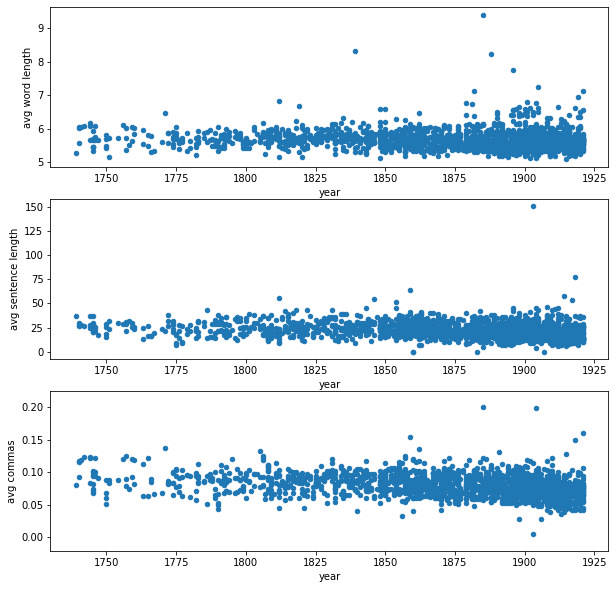

In [54]:
_, axs = plt.subplots(3, figsize=(10, 10))
features.plot.scatter(x='year', y='avg word length', ax=axs[0])
features.plot.scatter(x='year', y='avg sentence length', ax=axs[1])
_ = features.plot.scatter(x='year', y='avg commas', ax=axs[2])

These features don't appear to have terribly much predictive power. However, they are somewhat informative: they indicate potential [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) in the data. This means that the variability of the data is correlated to the data itself. The gradual "spread" in time in the above scatter plots is a hallmark of heteroscedasticity. Since the spread is quite slight, it may not actually be an issue.

## Representation: Bag-of-words

A more refined analysis can be obtained by using word frequencies as features. This can be done using a [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model), in which a text is represented as a vector whose components components correspond to words in a vocabulary. The values of a component is a measure of the frequency of that word in the document.

Simply counting the number of occurences of a word is often a poor measure of frequency, as it may merely be indicative of text size (however, it is sensible in some situations, such as when performing classification with multinomial [naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)). A better solution would be to scale by the total number of words in a text.

An even more sophisticated approach is to look at the frequency of a word in a text in comparison to its frequency  in a corpus of texts. This is accomplished by the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), or term frequency-inverse document frequency.

Below we use a tf-idf vectorizer with a minimum document frequency of 0.2 to filter out very uncommon words (e.g. typos). Note that we don't remove stop words, which are known to be useful in stylometry.

In [438]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.2)
X = vectorizer.fit_transform(segments['text'])

CPU times: user 2min 3s, sys: 11.8 s, total: 2min 15s
Wall time: 2min 20s


The resulting matrix `X` contains one row per text segment and each row has length equal to the vocabulary fit by the vectorizer (which results from our choice of `min_df`). Each row will act as an input variable.

In [392]:
print('Number of segments: {}\nVocabulary size: {}'.format(X.shape[0], X.shape[1]))

Number of segments: 14005
Vocabulary size: 2596


Note that `X` has type `csr_matrix`.

In [393]:
type(X)

scipy.sparse.csr.csr_matrix

This is because bag-of-words vectors are typically sparse: they will contain many 0 entries corresponding to absences of vocabulary words in a text. The `size` attribute of a `csr_matrix` indicates the number of non-zero values it contains, so we can compute the sparsity of `X` as follows.

In [394]:
1 - X.size / X.todense().size

0.5587712730815375

Actually, this isn't terribly sparse and it's probably due to the fact that our text segments are rather long.

In any case, we're going to shift and scale the rows of `X` to have zero mean and unit variance in order to improve convergence time of our learning algorithms. Since this eliminates sparsity, we have to convert `X` to a dense matrix.

In [442]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X.todense())

Next, we construct the target variables `y` from the corresponding publication dates and split `(X, y)` into training and test sets.

In [396]:
y = segments['year']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Visualization

We can attempt to visualize the bag-of-words vectors by applying a dimensional reduction technique. First, we'll attempt to extract two well-separated components by looking at those data points with target (year) below the first quartile and those above the third quartile.

In [560]:
q1 = segments['year'].quantile(0.25)
q3 = segments['year'].quantile(0.75)

X_split = X[(segments['year'] < q1) | (segments['year'] > q3)]
y_split = y[(segments['year'] < q1) | (segments['year'] > q3)]

We'll use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for dimensionality reduction.

In [574]:
tsne = TSNE()
result = tsne.fit_transform(X_split)

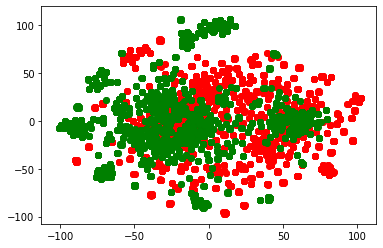

In [582]:
result1 = result[y_split < q1]
result3 = result[y_split > q3]

plt.scatter(result1[:, 0], result1[:, 1], c='r')
_ = plt.scatter(result3[:, 0], result3[:, 1], c='g')

This might not be terribly convincing, but we've lost a lot of information in the 2-dimensional projection. Still, we can detect what appears to be a small amount of separation between the two point clouds. An particularly interesting feature of the green cloud that deserves further investigation is the "hole" in the upper-right quandrant, seen more clearly below.

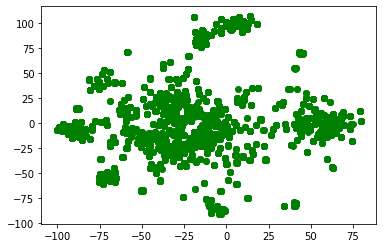

In [583]:
_ = plt.scatter(result3[:, 0], result3[:, 1], c='g')

## Ordinary least squares

We begin by applying simple linear regression to our bag-of-words vectors. We'll split our data into training and test sets in order to evaluate our model.

In [348]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [349]:
%%time
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

CPU times: user 26.5 s, sys: 253 ms, total: 26.7 s
Wall time: 13.7 s


0.8993817653134695

This is pretty good for such a simple model. However note that the training score is a bit higher.

In [343]:
linreg.score(X_train, y_train)

0.9999999654835877

We're overfitting, which isn't surprising since we haven't used any form of regularization or cross-validation.

Before addressing that, let's take a more detailed look at the model we've built. The $R^2$ score above is a rather crude metric. We can visualize the precise errors with a scatter plot.

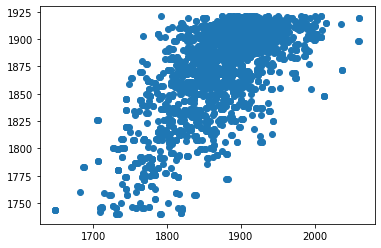

In [457]:
_ = plt.scatter(linreg.predict(X_test), y_test)

A perfect model would have all the points on the line $y = x$. Above, we see that, while our model appears to be correct *on average*, it makes quite a lot of mistakes: in fact, the spread of estimated years for a given true year appears to be about a century.

## Lasso

Due to sparsity of bag-of-word vectors, it's natural to consider the [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)?wprov=srpw1_0) method for this problem.

Lasso penalizes the $L_1$ norm of the regression coefficients and this is known to result in sparse regression coefficients. This is sensible in our case because there may be many words in the vocabulary that are not indicative of time period; lasso will select these automatically.

In [397]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(n_alphas=3, cv=2)
lassocv.fit(X_train, y_train)
lassocv.score(X_test, y_test)

/home/ben/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19990.05836734002, tolerance: 918.0698998214923
  tol, rng, random, positive)
/home/ben/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21672.673878368936, tolerance: 939.6974891824347
  tol, rng, random, positive)
/home/ben/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58959.74026110036, tolerance: 1857.9850241699398
  positive)


0.9542528749710253

Although the algorithm complains about convergence, it's performing well and we're certainly overfitting less than with ordinary least squares.

The scatter plot below also confirms the superiority of this model.

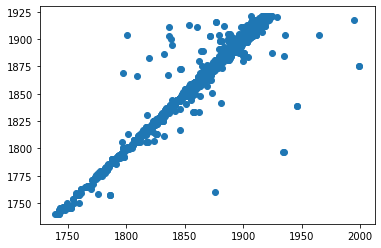

In [587]:
_ = plt.scatter(lassocv.predict(X_test), y_test)

We would also like to be able to explain why our model works.

## Neural net regression

Although neural nets are probably most famous for classification tasks, they are highly versatile and can be used in many learning tasks, including regression as well as unsupervised learning. For linear regression with a feedforward network, all we need to do is specify a linear activation function on the last layer and use the mean squared error loss function.

In [145]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

In [146]:
model = Sequential()
model.add(Dense(250, input_dim=d))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Neural networks are very sensitive to data scaling, so we perform some additional preprocessing before training our network.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X.todense())
y = sc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [147]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
11204/11204 [==============================] - 11s 952us/step - loss: 3.2845
Epoch 2/10
11204/11204 [==============================] - 9s 800us/step - loss: 0.2613
Epoch 3/10
11204/11204 [==============================] - 10s 856us/step - loss: 0.1473
Epoch 4/10
11204/11204 [==============================] - 9s 823us/step - loss: 0.1099
Epoch 5/10
11204/11204 [==============================] - 10s 918us/step - loss: 0.0904
Epoch 6/10
11204/11204 [==============================] - 10s 872us/step - loss: 0.0802
Epoch 7/10
11204/11204 [==============================] - 10s 901us/step - loss: 0.0712
Epoch 8/10
11204/11204 [==============================] - 15s 1ms/step - loss: 0.0620
Epoch 9/10
11204/11204 [==============================] - 15s 1ms/step - loss: 0.0624
Epoch 10/10
11204/11204 [==============================] - 15s 1ms/step - loss: 0.0545


In [148]:
model.evaluate(X_test, y_test)

2801/2801 [==============================] - 1s 394us/step


0.06415101153771395